# Neonatal brain measure estimation from dHCP data
As dHCP is under data protection, no data is included in this repository. The code is provided as a reference for the analysis of the dHCP data. To reproduce the analyses, you need to apply for access to the dHCP dataset [here](https://nda.nih.gov/edit_collection.html?id=3955), and parcellate the data with the [MCRIBS atlas](https://github.com/DevelopmentalImagingMCRI/MCRIBS). Change the directory `mcribs_data_dir` accordingly. 

I received parcellated data from my collaborators C. Adamson, G. Ball, R. Beare, and J.A.S. de Almeida.

This whole notebook should be run for cortical thickness (CT) or surface area (SA). Both measures were used in the original publication. Adjust the variable `brain_measure` to `CT` or `SA` accordingly. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce
from abagen import fetch_desikan_killiany

import sys
sys.path.append('code')
#from preprocessing import dhcp_aparcstats2table, 
from utils import reorder_vars, dhcp_strip_id, dhcp_format_interview_date, dhcp_read_meta, dhcp_assign_scan_label


dhcp_data_dir = 'data/dHCP'
mcribs_data_dir = 'data/dHCP/rel3/dhcp-MCRIBS'  # where MCRIBS parcellated data are saved
dhcp_data_dir_rel = 'data/dHCP/rel3'  # where the dHCP data are saved

# dhcp_freesurfer_outputs = join(dhcp_data_dir, 'freesurfer')  # where all freesurfer outputs are stored
dhcp_out = join(dhcp_data_dir, 'derivatives')  # where the adapted data will be stored
os.makedirs(dhcp_out, exist_ok=True)


# adjust brain measurement for which the code should be run
brain_measure = 'CT'  # CT or SA

# Load MRI related data
The dHCP dataset has been published in several releases. Data from release 2 and 3 will be used here. MRI data were parcellated using the MCRIBS atlas, which is a neonatal brain atlas developed by [Chris Adamson and colleagues](https://doi.org/10.1038/s41598-020-61326-2). The MCRIBS atlas is available on [GitHub](https://github.com/DevelopmentalImagingMCRI/MCRIBS). The output generated by MCRIBS is similar to FreeSurfer's ?.aparc.annot files and corresponds to the parcellation of the adult Desikan-Killiany atlas.

In [3]:
# define aseg columns to be extracted
aseg_cols = ['SubCortGrayVol', 'CerebralWhiteMatterVol', 'CortexVol']

### Release 2

In [4]:
# aseg
rel2_aseg = pd.read_csv(join(mcribs_data_dir, 'dHCP2_aseg.csv'), index_col=0, sep=',')
rel2_aseg.index.name = 'participant'  
rel2_aseg = rel2_aseg[aseg_cols] 

# brain measure
if brain_measure == 'CT':
    rel2_mri_lh = pd.read_csv(join(mcribs_data_dir, 'dHCP2_lh.dkt.ThickAvg.csv'), index_col=0, sep=',')
    rel2_mri_rh = pd.read_csv(join(mcribs_data_dir, 'dHCP2_rh.dkt.ThickAvg.csv'), index_col=0, sep=',')
    rel2_mri = rel2_mri_lh.merge(rel2_mri_rh, on='ThickAvg')
elif brain_measure == 'SA':
    rel2_mri_lh = pd.read_csv(join(mcribs_data_dir, 'dHCP2_lh.dkt.SurfArea.csv'), index_col=0, sep=',')
    rel2_mri_rh = pd.read_csv(join(mcribs_data_dir, 'dHCP2_rh.dkt.SurfArea.csv'), index_col=0, sep=',')
    rel2_mri = rel2_mri_lh.merge(rel2_mri_rh, on='SurfArea')
else: 
    raise ValueError("brain_measure must be either 'CT' or 'SA'")

# drop medial wall columns and rename index
rel2_mri.drop(columns=['Medial_Wall_x', 'Medial_Wall_y'], inplace=True)  # remove participant column as it is not needed
rel2_mri.index.name = 'participant'  

# merge brain_measure and aseg data
rel2 = rel2_mri.merge(rel2_aseg, on='participant', how='outer')

# separate session and participant id
rel2 = dhcp_strip_id(rel2)
rel2['release'] = 2

### Release 3

In [5]:
# aseg
rel3_aseg = pd.read_csv(join(mcribs_data_dir, 'dHCP3_aseg.csv'), index_col=0, sep=',')
rel3_aseg.index.name = 'participant'  
rel3_aseg = rel3_aseg[aseg_cols]

# brain measure
if brain_measure == 'CT':
    rel3_mri_lh = pd.read_csv(join(mcribs_data_dir, 'dHCP3_lh.dkt.ThickAvg.csv'), index_col=0, sep=',')
    rel3_mri_rh = pd.read_csv(join(mcribs_data_dir, 'dHCP3_rh.dkt.ThickAvg.csv'), index_col=0, sep=',')
    rel3_mri = rel3_mri_lh.merge(rel3_mri_rh, on='ThickAvg')
elif brain_measure == 'SA':
    rel3_mri_lh = pd.read_csv(join(mcribs_data_dir, 'dHCP3_lh.dkt.SurfArea.csv'), index_col=0, sep=',')
    rel3_mri_rh = pd.read_csv(join(mcribs_data_dir, 'dHCP3_rh.dkt.SurfArea.csv'), index_col=0, sep=',')
    rel3_mri = rel3_mri_lh.merge(rel3_mri_rh, on='SurfArea')
else: 
    raise ValueError("brain_measure must be either 'CT' or 'SA'")

# drop medial wall columns and rename index
rel3_mri.drop(columns=['Medial_Wall_x', 'Medial_Wall_y'], inplace=True)  # remove participant column as it is not needed
rel3_mri.index.name = 'participant'  

# merge brain_measure and aseg data
rel3 = rel3_mri.merge(rel3_aseg, on='participant', how='outer')

# separate session and participant id
rel3 = dhcp_strip_id(rel3)
rel3['release'] = 3


In [6]:
# combine release 2 and 3
dhcp_mri = pd.concat([rel2, rel3], axis=0)
dhcp_mri.sort_values(by=['Subject_ID', 'Session_ID'], inplace=True)
print(f"Combined dHCP data shape: {dhcp_mri.shape}")


# get region names of the Desikan-Killiany atlas as now used in the dHCP data
dhcp_idps_idx_wo_nan = dhcp_mri.filter(regex=f'ctx-').columns
print(f"Number of IDPs in DKT atlas: {len(dhcp_idps_idx_wo_nan)}")

# mean CT
if brain_measure == 'CT':
    dhcp_mri['meanCT2'] = dhcp_mri[dhcp_idps_idx_wo_nan].mean(axis=1)

Combined dHCP data shape: (852, 68)
Number of IDPs in DKT atlas: 62


# Match DKT to DK atlas
Some regions are missing (bankssts, frontalpole, temporalpole)

In [7]:
# access DK atlas and save idp_labels
atlas = fetch_desikan_killiany(surface=True)
atlas = pd.read_csv(atlas['info'])
atlas = atlas[(atlas['structure'] == 'cortex') & (atlas['hemisphere'] == 'L')]
atlas_labels_l = ['L_'+label for label in atlas['label']]
atlas_labels_r = ['R_'+label for label in atlas['label']]

desikan_idps = atlas_labels_l + atlas_labels_r  # save correct labels to rename the columns later

In [8]:
# add NaN columns for the regions that are not present in the dHCP data
dhcp_mri['ctx-lh-bankssts'] = np.nan
dhcp_mri['ctx-lh-frontalpole'] = np.nan
dhcp_mri['ctx-lh-temporalpole'] = np.nan
dhcp_mri['ctx-rh-bankssts'] = np.nan
dhcp_mri['ctx-rh-frontalpole'] = np.nan
dhcp_mri['ctx-rh-temporalpole'] = np.nan

In [9]:
# reorder columns of dhcp_mri
dk_labels_raw = atlas['label'].tolist()
dk_labels_dhcp = [f'ctx-{hemisphere}-{label}' for hemisphere in ['lh', 'rh'] for label in dk_labels_raw]
dhcp_mri = reorder_vars(['Subject_ID', 'Session_ID', 'release'], dhcp_mri, dk_labels_dhcp)

# sorting dhcp_idps_idx
dhcp_idps_idx = dhcp_mri.filter(regex=f'ctx-').columns

### Meta information

In [10]:
# load meta information
meta = dhcp_read_meta(join(dhcp_data_dir_rel, 'nnsi01.txt'))
meta = meta[['src_subject_id', 'interview_date', 'sex', 'nscan_ga_at_birth_weeks', 'nscan_ga_at_scan_weeks', 
            'radiology_score', 'scan_validation']]
meta['scan_validation'] = ['ses-' + str(ses) for ses in meta['scan_validation']] 

# rename columns and adjust data types
meta.rename(columns={'src_subject_id': 'Subject_ID', 
                    'scan_validation': 'Session_ID',
                    'nscan_ga_at_birth_weeks': 'gestational_age', 
                    'nscan_ga_at_scan_weeks': 'scan_age'}, inplace=True)

meta['scan_age'] = meta['scan_age'].astype(float)
meta['gestational_age'] = meta['gestational_age'].astype(float)

# format interview date to be consistent across subjects
meta['interview_date_formatted'] = meta['interview_date'].apply(dhcp_format_interview_date)
meta.drop(columns=['interview_date'], inplace=True)

# assign session and scan labels
meta['session'] = meta.groupby('Subject_ID').cumcount() + 1
meta['scan'] = meta.apply(dhcp_assign_scan_label, axis=1)

### Merge meta with mri data and only keep subjects with at least one term-equ scan

In [11]:
dhcp = dhcp_mri.merge(meta, on=['Subject_ID', 'Session_ID'], how='inner')

In [12]:
# only keep subjects with at least one scan at term-equivalent age
subs_with_term_scan = dhcp[dhcp['scan'] == 'term_equivalent']['Subject_ID'].unique()
dhcp = dhcp[dhcp['Subject_ID'].isin(subs_with_term_scan)]
print(f"Final dHCP data shape: {dhcp.shape}")

Final dHCP data shape: (783, 82)


# Load data about cognition, birth, and SES

In [13]:
dhcp_tab_data = {
    join(dhcp_data_dir_rel, 'bsid_iii01.txt'):  ['bsid_cog_composite'], 
    join(dhcp_data_dir_rel, 'cpenr01.txt'):     ['mother_education1', 'mother_occupation', 'father_education1', 'father_occupation'], 
    join(dhcp_data_dir_rel, 'lpb01.txt'):       ['baby_birth_weight'], 
}

# read data
dhcp_tab = []
for k in dhcp_tab_data.keys():
    tab = pd.read_csv(k, header=0, skiprows=[1], delimiter="\t", na_values=['-998', '-999', ''], 
                        low_memory=False)
    tab = tab[["src_subject_id"] + dhcp_tab_data[k]]     
    dhcp_tab.append(tab)
    
# combine data
dhcp_tab = reduce(lambda left, right: pd.merge(left, right, on=["src_subject_id"], how='left'), dhcp_tab)

# rename columns
dhcp_tab.rename(columns={'src_subject_id': 'Subject_ID',
                        'baby_birth_weight': 'BW'}, inplace=True)

# transform BW into grams
dhcp_tab['BW'] = dhcp_tab['BW'] * 1000  # convert kg to grams


In [14]:
dhcp = dhcp_mri.merge(meta, on=['Subject_ID', 'Session_ID'], how='inner')

In [15]:
# only keep subjects with at least one scan at term-equivalent age
subs_with_term_scan = dhcp[dhcp['scan'] == 'term_equivalent']['Subject_ID'].unique()
dhcp = dhcp[dhcp['Subject_ID'].isin(subs_with_term_scan)]
print(f"Final dHCP data shape: {dhcp.shape}")

Final dHCP data shape: (783, 82)


# Load data about cognition, birth, and SES

In [16]:
dhcp_tab_data = {
    join(dhcp_data_dir_rel, 'bsid_iii01.txt'):  ['bsid_cog_composite'], 
    join(dhcp_data_dir_rel, 'cpenr01.txt'):     ['mother_education1', 'mother_occupation', 'father_education1', 'father_occupation'], 
    join(dhcp_data_dir_rel, 'lpb01.txt'):       ['baby_birth_weight'], 
}

# read data
dhcp_tab = []
for k in dhcp_tab_data.keys():
    tab = pd.read_csv(k, header=0, skiprows=[1], delimiter="\t", na_values=['-998', '-999', ''], 
                        low_memory=False)
    tab = tab[["src_subject_id"] + dhcp_tab_data[k]]     
    dhcp_tab.append(tab)
    
# combine data
dhcp_tab = reduce(lambda left, right: pd.merge(left, right, on=["src_subject_id"], how='left'), dhcp_tab)

# rename columns
dhcp_tab.rename(columns={'src_subject_id': 'Subject_ID',
                        'baby_birth_weight': 'BW'}, inplace=True)

# transform BW into grams
dhcp_tab['BW'] = dhcp_tab['BW'] * 1000  # convert kg to grams


In [17]:
# Calculate SES based on parental education length
# average parental educational attainment
dhcp_tab["SES_parent_education"] = np.where(
    dhcp_tab['father_education1'].isna(), dhcp_tab['mother_education1'],  # if education_parent1 is nan, use education_parent2
    np.where(dhcp_tab['mother_education1'].isna(), dhcp_tab['father_education1'],  # if education_parent2 is nan, use education_parent1 
            (dhcp_tab['mother_education1'] + dhcp_tab['father_education1']) / 2)  # if both are available, take the mean
)

# Adjust and rename variables

In [18]:
# merge 
dhcp = dhcp.merge(dhcp_tab, on=['Subject_ID'], how='left') 


# rename variables
dhcp = dhcp.rename(columns=dict(
    SubCortGrayVol="sGMV",
    CerebralWhiteMatterVol="WMV",
    CortexVol="GMV"
))  

# reorder variables to match the Desikan-Killiany atlas
dhcp = dhcp.rename(columns=dict(zip(dhcp_idps_idx, desikan_idps)))

In [19]:
# add preterm variable
dhcp['dx'] = np.where(dhcp['gestational_age'] < 37, 'preterm', 'CN')

# Average hemispheres

In [20]:
regions = [r[2:] for r in desikan_idps[:34]]

# Combine L_ and R_ values
for region in regions:
    dhcp[f'{brain_measure}_{region}'] = dhcp[[f'L_{region}', f'R_{region}']].mean(axis=1)
    # drop L_ and R_ columns
    dhcp = dhcp.drop(columns=[f'L_{region}', f'R_{region}'])

In [21]:
# create region list bilateral
desikan_idps_bilateral = [f'{brain_measure}_{region}' for region in regions]
ctv_columns = ['GMV', 'WMV', 'sGMV']

In [22]:
# FILTER FOR TERM-EQ
# # select the preterm subjects with two scans (i.e., one at birth, one at term-equivalent age)
# preterm_scan_2 = dhcp[dhcp['dx'] == 'preterm']
# preterm_scan_2 = preterm_scan_2[preterm_scan_2['scan'] == 'term_equivalent']
# print("{0} preterm subjects have a scan at term-equivalent age.".format(preterm_scan_2.shape[0]))

# # make sure that there are no subjects with 2 term-equivalent scans
# print("Number of duplicates: {0}".format(preterm_scan_2.Subject_ID.duplicated().sum()))

# CN_scan_1 = dhcp[dhcp['dx'] == 'CN']
# print(f"{CN_scan_1.shape[0]} term subjects are selected.")

# Adapt df for BrainChart framework
BrainChart needs a certain format of the data. We will adapt the data accordingly. More information can be found [here](https://brainchart.shinyapps.io/brainchart/).

In [23]:
# adapt for brainchart
dhcp = dhcp.rename(columns=dict(
    Subject_ID="participant",
    gestational_age="GA",
    baby_birth_weight="BW",
)) 

# sex
dhcp['sex'] = dhcp['sex'].replace({'F': 'Female', 'M': 'Male'})

# age
dhcp['age_days'] = dhcp['scan_age'] * 7  # because scan_age is in weeks
dhcp['Age'] = (dhcp['age_days']-280) / 365.245  # from BrainChart instructions

# other required info
dhcp['study'] = 'dHCP_NewEstimation'  # as dHCP was used for original model fitting, we want to make sure that random effects of study are calculated again
dhcp['fs_version'] = 'Custom' 
dhcp['country'] = 'Multisite'
dhcp['run'] = 1

# reshape
all_idps = desikan_idps_bilateral + ctv_columns
dhcp_final = reorder_vars(['participant', 'Age', 'age_days', 'sex', 'study', 'fs_version','country', 'run', 
                            'session', 'dx'], dhcp, all_idps)

# save
print('Final data shape:', dhcp_final.shape)
dhcp_final.to_csv(os.path.join(dhcp_out, f'dHCP_{brain_measure}_preprocessed.csv'), index=False)


Final data shape: (783, 63)


# Stats
Summary stats shown in Supp Table S1.

In [24]:
# test=dhcp_final[dhcp_final['dx']=='CN']
# test = test[test['scan'] == 'term_equivalent']
# test.groupby('sex').describe()

cn = dhcp_final.loc[(dhcp_final.scan=='term_equivalent') & (dhcp_final.dx=='CN')]
(cn['sex'] == "Male").sum() / len(cn.sex) * 100

53.086419753086425

In [25]:
dhcp_final['age_weeks'] = dhcp_final['age_days'] / 7

dhcp_final_pt = dhcp_final[dhcp_final['dx'] == 'preterm']
dhcp_final_cn = dhcp_final[dhcp_final['dx'] == 'CN']

# summary statistics
dhcp_sample_stats = dict()
for tp in ["fetal", "term_equivalent"]:
    print(f"---- STATS FOR {tp} SCANS ----")
    cn = dhcp_final.loc[(dhcp_final.scan==tp) & (dhcp_final.dx=='CN')]
    pt = dhcp_final.loc[(dhcp_final.scan==tp) & (dhcp_final.dx=='preterm')]

    print(f"Data available for {len(cn)} term subjects and {len(pt)} preterm subjects")

    # age
    dhcp_sample_stats[("CN", tp, "Age [weeks]")] = cn['age_weeks'].describe()
    dhcp_sample_stats[("preterm", tp, "Age [weeks]")] = pt['age_weeks'].describe()
    
    # sex
    dhcp_sample_stats[("CN", tp, "Male [%]")] = pd.Series({
        "count": len(cn.sex),
        "%": (cn['sex'] == "Male").sum() / len(cn.sex) * 100
    })
    
    dhcp_sample_stats[("preterm", tp, "Male [%]")] = pd.Series({
        "count": len(pt.sex),
        "%": (pt['sex'] == "Male").sum() / len(pt.sex) * 100 
    })
    
    # GA
    dhcp_sample_stats[("CN", tp, "GA [weeks]")] = cn['GA'].describe()
    dhcp_sample_stats[("preterm", tp, "GA [weeks]")] = pt['GA'].describe()
    
    # BW
    dhcp_sample_stats[("CN", tp, "BW [g]")] = cn['BW'].describe()
    dhcp_sample_stats[("preterm", tp, "BW [g]")] = pt['BW'].describe()
    

dhcp_sample_stats = pd.DataFrame(dhcp_sample_stats).sort_index(axis=1)
dhcp_sample_stats = dhcp_sample_stats.loc[["count", "mean", "%", "std", "50%", "min", "max"],:]
dhcp_sample_stats = dhcp_sample_stats.rename(index={"count":"n", "50%":"median", "std":"sd"})
dhcp_sample_stats = dhcp_sample_stats.round(2)
dhcp_sample_stats


---- STATS FOR fetal SCANS ----
Data available for 0 term subjects and 82 preterm subjects
---- STATS FOR term_equivalent SCANS ----
Data available for 567 term subjects and 134 preterm subjects


/var/folders/tk/3rqd03yd6rqb4_przznzwzjc0000gn/T/ipykernel_75496/3242594952.py:22: RuntimeWarning: invalid value encountered in long_scalars
  "%": (cn['sex'] == "Male").sum() / len(cn.sex) * 100


CN                                                      \
             fetal                            term_equivalent            
       Age [weeks] BW [g] GA [weeks] Male [%]     Age [weeks]   BW [g]   
n              0.0    0.0        0.0      0.0          567.00   454.00   
mean           NaN    NaN        NaN      NaN           41.39  3391.90   
%              NaN    NaN        NaN      NaN             NaN      NaN   
sd             NaN    NaN        NaN      NaN            1.73   495.23   
median         NaN    NaN        NaN      NaN           41.43  3415.00   
min            NaN    NaN        NaN      NaN           37.43  1820.00   
max            NaN    NaN        NaN      NaN           44.86  4750.00   

                               preterm                               \
                                 fetal                                
       GA [weeks] Male [%] Age [weeks]   BW [g] GA [weeks] Male [%]   
n          567.00   567.00       82.00    66.00      82.00    82.00   
mean        39.99      NaN       33.41  1522.65      30.47      NaN   
%             NaN    53.09         NaN      NaN        NaN    52.44   
sd           1.27      NaN        2.34   643.19       3.55      NaN   
median      40.14      NaN       33.50  1365.00      30.57      NaN   
min         37.00      NaN       26.71   540.00      23.57      NaN   
max         43.00      NaN       36.86  3050.00      36.00      NaN   

                                                     
       term_equivalent                               
           Age [weeks]   BW [g] GA [weeks] Male [%]  
n               134.00   104.00     134.00   134.00  
mean             40.82  1735.73      31.87      NaN  
%                  NaN      NaN        NaN    55.22  
sd                2.10   721.81       3.84      NaN  
median           40.86  1685.00      32.29      NaN  
min              37.00   540.00      23.57      NaN  
max              45.14  3280.00      36.86      NaN

# Split dhcp-fetal and dhcp-term_equivalent

In [26]:
dhcp_fetal = dhcp_final[dhcp_final['scan'] == 'fetal']
dhcp_termeq = dhcp_final[dhcp_final['scan'] == 'term_equivalent']

# save
dhcp_fetal.to_csv(os.path.join(dhcp_out, f'dHCP-fetal_{brain_measure}_preprocessed.csv'), index=False)
dhcp_termeq.to_csv(os.path.join(dhcp_out, f'dHCP-termequ_{brain_measure}_preprocessed.csv'), index=False)

# Split dhcp-fetal and dhcp-term_equivalent

In [27]:
dhcp_fetal = dhcp_final[dhcp_final['scan'] == 'fetal']
dhcp_termeq = dhcp_final[dhcp_final['scan'] == 'term_equivalent']

# save
dhcp_fetal.to_csv(os.path.join(dhcp_out, f'dHCP-fetal_{brain_measure}_preprocessed.csv'), index=False)
dhcp_termeq.to_csv(os.path.join(dhcp_out, f'dHCP-termequ_{brain_measure}_preprocessed.csv'), index=False)

# Split dhcp-fetal and dhcp-term_equivalent

In [28]:
dhcp_fetal = dhcp_final[dhcp_final['scan'] == 'fetal']
dhcp_termeq = dhcp_final[dhcp_final['scan'] == 'term_equivalent']

# save
dhcp_fetal.to_csv(os.path.join(dhcp_out, f'dHCP-fetal_{brain_measure}_preprocessed.csv'), index=False)
dhcp_termeq.to_csv(os.path.join(dhcp_out, f'dHCP-termequ_{brain_measure}_preprocessed.csv'), index=False)

# Brain injury
Did subjects have WM injuries?
- 1: Normal appearance for age
- 2: Incidental findings with unlikely significance for clinical outcome or analysis (e.g. subdural haemorrhage. Isolated subependymal cysts. Mild Inferior vermis rotation)
- 3: Incidental findings with unlikely clinical significance but possible analysis significance (e.g. Several punctate lesions or other focal white matter/ cortical lesions not thought to be of clinical significance)
- 4: Incidental findings with possible clinical significance. Unlikely analysis significance (e.g. Isolated non brain anomaly e.g. in pituitary / on tongue)
- 5:  Incidental findings with possible/likely significance for both clinical and imaging analysis (e.g. Major lesions within white matter)

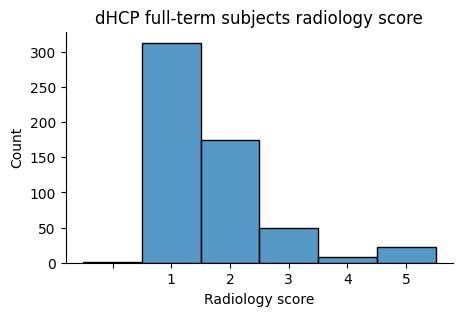

In [29]:
# fullterm subjects
dhcp_final_cn_hist = dhcp_final_cn.copy()
dhcp_final_cn_hist = dhcp_final_cn_hist.sort_values(by='radiology_score')

plt.figure(figsize=(5, 3))
sns.histplot(dhcp_final_cn_hist['radiology_score'], bins=5)
sns.despine()

plt.xlabel('Radiology score')
plt.ylabel('Count')
plt.title('dHCP full-term subjects radiology score')
plt.show()


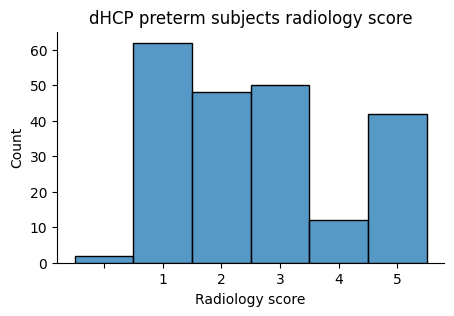

In [30]:
# preterm subjects
dhcp_final_pt_hist = dhcp_final_pt.copy()
dhcp_final_pt_hist = dhcp_final_pt_hist.sort_values(by='radiology_score')

plt.figure(figsize=(5, 3))
sns.histplot(dhcp_final_pt_hist['radiology_score'], bins=5)
sns.despine()

plt.xlabel('Radiology score')
plt.ylabel('Count')
plt.title('dHCP preterm subjects radiology score')
plt.show()